## CNN Transfer Learning using VGG-16 Updated
This notebook has been updated to incorporate paths and data handling from the SIFT notebook, ensuring a consistent approach in handling the dataset.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical


## Data Loading and Preprocessing
Here, we load and preprocess our image data, aligning with the methods used in the SIFT notebook.

In [3]:
import pandas as pd
import os

# Define relative path
file_path = os.path.join("..", "data", "flipkart_com-ecommerce_sample_1050.csv")

# Load the CSV in a DataFrame
df = pd.read_csv(file_path)

# first lignes of the df
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


### Import du dataset des images sous forme de fichiers jpg


Image: 009099b1f6e1e8f893ec29a7023153c4.jpg
 - Dimensions: (687, 1162)
 - Mode: RGB
------------------------------
Image: 0096e89cc25a8b96fb9808716406fe94.jpg
 - Dimensions: (1478, 904)
 - Mode: RGB
------------------------------
Image: 00cbbc837d340fa163d11e169fbdb952.jpg
 - Dimensions: (1347, 326)
 - Mode: RGB
------------------------------
Image: 00d84a518e0550612fcfcba3b02b6255.jpg
 - Dimensions: (1100, 857)
 - Mode: RGB
------------------------------
Image: 00e966a5049a262cfc72e6bbf68b80e7.jpg
 - Dimensions: (962, 1100)
 - Mode: RGB
------------------------------
Image: 00ed03657cedbe4663eff2d7fa702a33.jpg
 - Dimensions: (788, 2430)
 - Mode: RGB
------------------------------


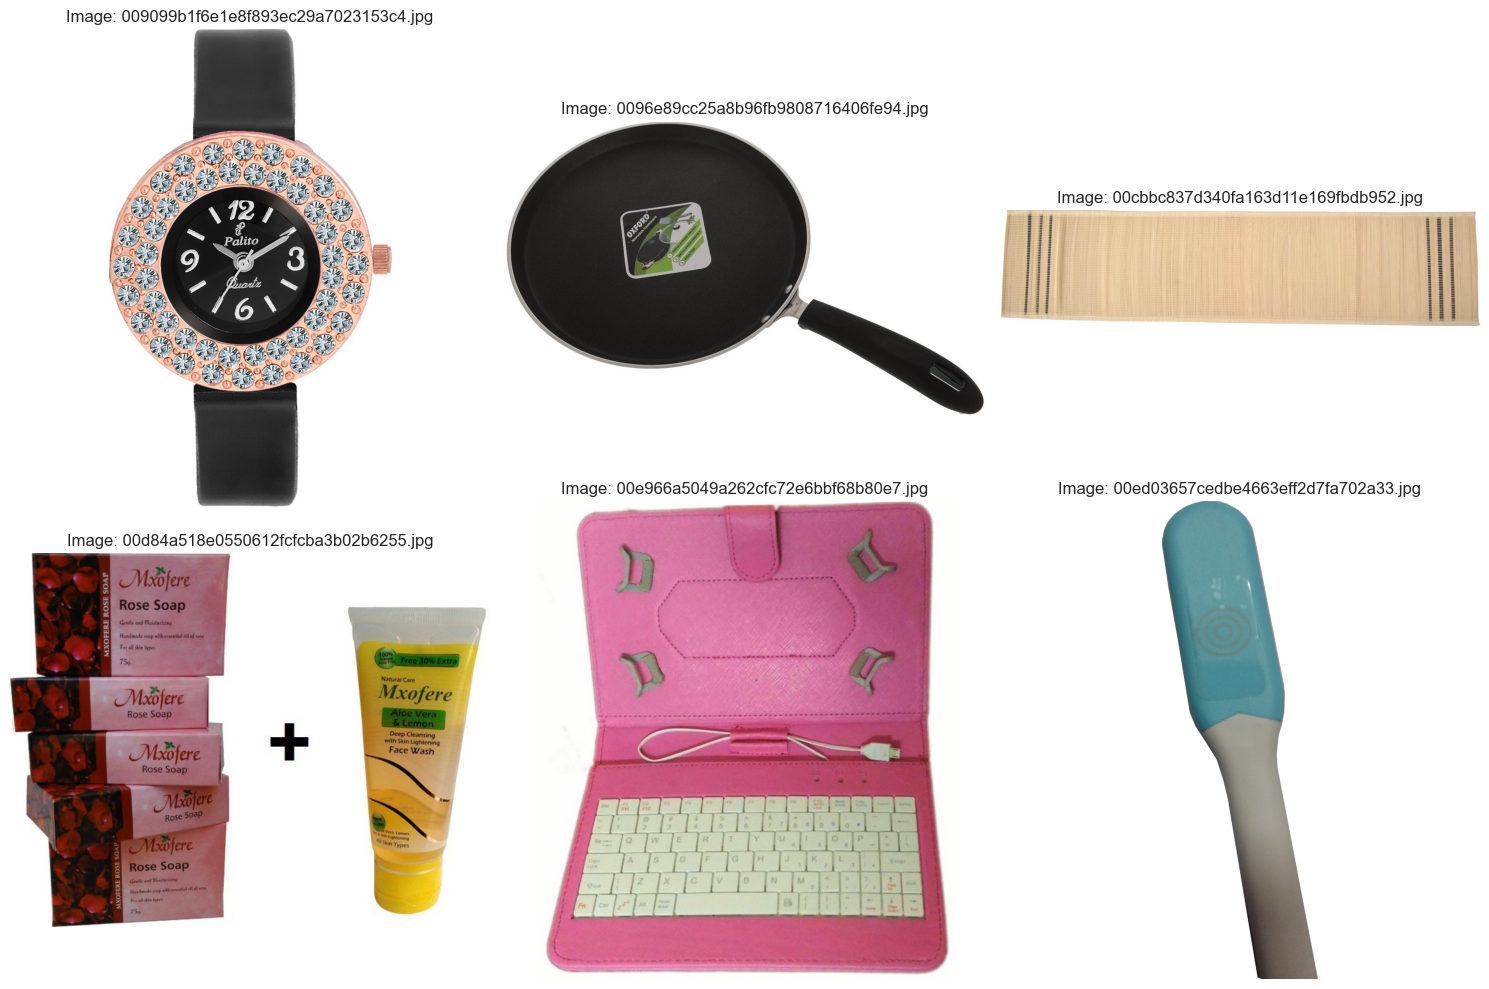

In [4]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Define the path to the folder containing the images
images_folder = os.path.join("..", "data", "Images")

# List all files in the folder
image_files = os.listdir(images_folder)

# Select the first 6 images
selected_images = image_files[:6]

# Set up the figure to display 6 images (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Load and display information about each image
for i, image_name in enumerate(selected_images):
    image_path = os.path.join(images_folder, image_name)
    image = Image.open(image_path)
    
    # Display information about the image
    print(f"Image: {image_name}")
    print(f" - Dimensions: {image.size}")
    print(f" - Mode: {image.mode}")
    print("-" * 30)
    
    # Display the image in the grid
    ax = axes[i // 3, i % 3]
    ax.imshow(image)
    ax.set_title(f"Image: {image_name}")
    ax.axis('off')  # Turn off the axes for better presentation

# Display the grid
plt.tight_layout()
plt.show()



In [5]:

import pandas as pd

# Load the data into a DataFrame
df = pd.read_csv('../data/flipkart_com-ecommerce_sample_1050.csv')

# Display the unique values in the 'product_category_tree' column
print(df['product_category_tree'].unique())

# Extract the first category from the 'product_category_tree' column
df['category'] = df['product_category_tree'].apply(lambda x: x.split('>>')[0].strip())
# Put category in lowercase
df['category'] = df['category'].apply(lambda x: x.lower())
# Display the unique values in the 'category' column
print(df['category'].unique())


['["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]'
 '["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y..."]'
 '["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotton Terry Face Towel Set (20 PIECE FA..."]'
 '["Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL FASHION Cotton Printed King sized ..."]'
 '["Home Furnishing >> Bed Linen >> Bedsheets >> Jaipur Print Bedsheets >> Jaipur Print Cotton Floral King sized Double Bed..."]'
 '["Watches >> Wrist Watches >> Maserati Time Wrist Watches"]'
 '["Watches >> Wrist Watches >> Camerii Wrist Watches"]'
 '["Watches >> Wrist Watches >> T STAR Wrist Watches"]'
 '["Watches >> Wrist Watches >> Alfajr Wrist Watches"]'
 '["Watches >> Wrist Watches >> TAG Heuer Wrist Watches"]'
 '["Watches >> Wrist Watches >> Calibro Wri

### Recuperation de la première catégorie de produits

In [6]:
# Display the unique values in the 'product_category_tree' column
df['product_category_tree'].unique()

array(['["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]',
       '["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y..."]',
       '["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotton Terry Face Towel Set (20 PIECE FA..."]',
       '["Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL FASHION Cotton Printed King sized ..."]',
       '["Home Furnishing >> Bed Linen >> Bedsheets >> Jaipur Print Bedsheets >> Jaipur Print Cotton Floral King sized Double Bed..."]',
       '["Watches >> Wrist Watches >> Maserati Time Wrist Watches"]',
       '["Watches >> Wrist Watches >> Camerii Wrist Watches"]',
       '["Watches >> Wrist Watches >> T STAR Wrist Watches"]',
       '["Watches >> Wrist Watches >> Alfajr Wrist Watches"]',
       '["Watches >> Wrist Watches >> T

In [7]:
# Extract the first category from the 'product_category_tree' column
df['category'] = df['product_category_tree'].apply(lambda x: x.split('>>')[0][2:-1])
# Put category in lowercase and in a list
df['category'] = df['category'].apply(lambda x: x.lower())
# Display the unique values in the 'category' column
df['category'].unique()

array(['home furnishing', 'baby care', 'watches',
       'home decor & festive needs', 'kitchen & dining',
       'beauty and personal care', 'computers'], dtype=object)

In [8]:
# Display the first few rows of the DataFrame
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,category
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",home furnishing
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",baby care
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",baby care
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",home furnishing
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",home furnishing


# Creation du dataframe pour le traitement des images

In [9]:
# Create a new DataFrame with the 'image' and 'category' columns
df_images = df.copy()
df_images = df_images[['image', 'category']]
df_images.head()

,image,category
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,home furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,baby care
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,baby care
3,d4684dcdc759dd9cdf41504698d737d8.jpg,home furnishing
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,home furnishing


### Création colonne label dans le DataFrame

In [10]:
from sklearn import preprocessing

# Initialize the label encoder
le = preprocessing.LabelEncoder()

# Fit the label encoder to the 'category' column
le.fit(df_images['category'])

# Transform the 'category' column to create a new 'label' column
df_images['label'] = le.transform(df_images['category'])

# Create a mapping from category labels to numeric labels
category_to_label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

# Display the mapping
print("Category to Label Mapping:")
print(category_to_label_mapping)

# Display the updated DataFrame with the new 'label' column
df_images.head(6)


Category to Label Mapping:
{'baby care': 0, 'beauty and personal care': 1, 'computers': 2, 'home decor & festive needs': 3, 'home furnishing': 4, 'kitchen & dining': 5, 'watches': 6}


,image,category,label
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,home furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,baby care,0
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,baby care,0
3,d4684dcdc759dd9cdf41504698d737d8.jpg,home furnishing,4
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,home furnishing,4
5,893aa5ed55f7cff2eccea7758d7a86bd.jpg,watches,6


In [11]:
df_images.groupby("label").count()

,image,category
label,,
0,150,150
1,150,150
2,150,150
3,150,150
4,150,150
5,150,150
6,150,150


In [12]:
print(df_images.columns)


Index(['image', 'category', 'label'], dtype='object')


baby care


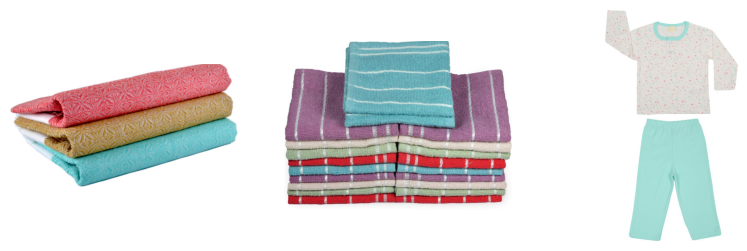

beauty and personal care


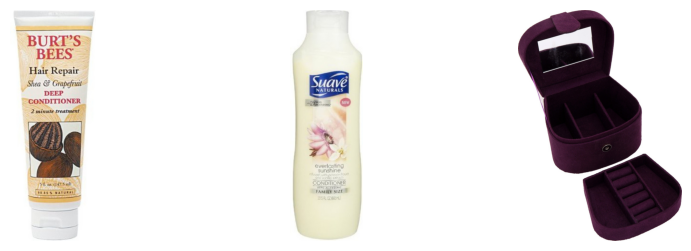

computers


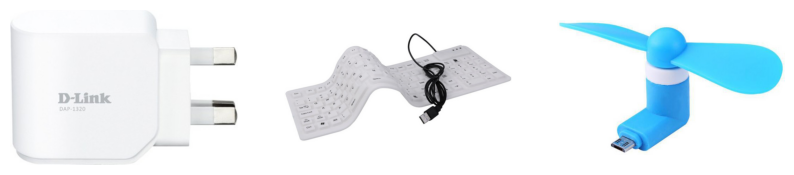

home decor & festive needs


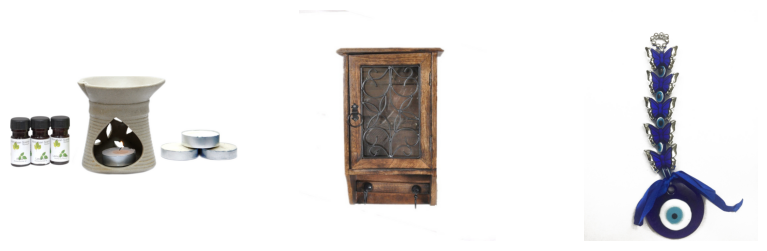

home furnishing


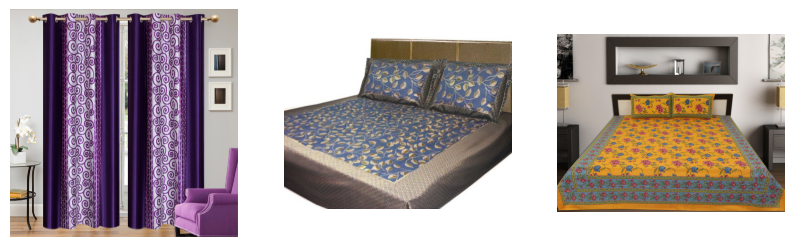

kitchen & dining


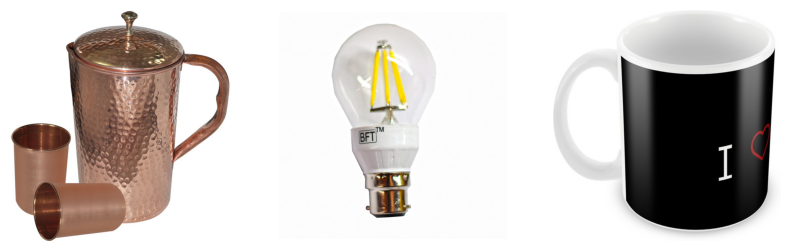

watches


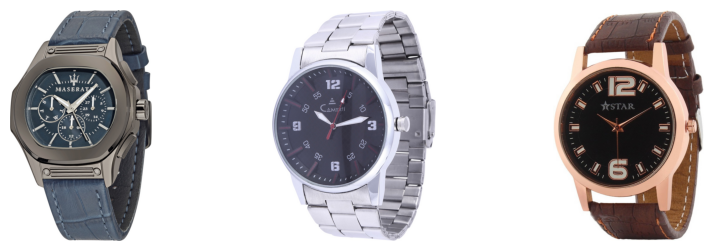

In [13]:
from matplotlib.image import imread
import matplotlib.pyplot as plt
import os

# Updated category-to-label mapping based on your mapping
category_to_label_mapping = {
    'baby care': 0, 
    'beauty and personal care': 1, 
    'computers': 2, 
    'home decor & festive needs': 3, 
    'home furnishing': 4, 
    'kitchen & dining': 5, 
    'watches': 6
}

# Function to return a list of image paths based on textual category
def list_images_by_category(df, category):
    label = category_to_label_mapping[category]
    return df[df['label'] == label]['image'].tolist()

# Display three images for each category
for category in category_to_label_mapping.keys():
    print(category)
    image_list = list_images_by_category(df_images, category)
    plt.figure(figsize=(10, 3))  # Adjust the size of the figure for better visibility
    for i in range(min(3, len(image_list))):  # Display up to 3 images, or fewer if not available
        plt.subplot(1, 3, i + 1)  # Configuration for a row of 3 images
        filename = os.path.join(images_folder, image_list[i])  # Ensure that images_folder is correctly defined
        image = imread(filename)
        plt.imshow(image)
        plt.axis('off')  # Turn off the axes for better visibility
    plt.show()



# Etape 1 : étude de faisabilité

## Création du model pré-entrainé

## Model Setup
Set up the CNN model using VGG-16, adapted to the project's specific requirements.

In [14]:
# this line initializes the VGG16 model with weights trained on the ImageNet dataset. By default, it includes the top fully connected layers.
base_model = VGG16() 

# This line creates a new model that uses the same inputs as the VGG16 model but only outputs from the second-to-last layer of the VGG16. This is often done to use the model as a feature extractor in transfer learning scenarios, where the convolutional base of the model is used to extract features that are then used to train a new classifier.
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

# This line prints a summary of the model architecture, showing the layers and the number of parameters in each layer.
print(model.summary())


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


### Observations :
1. **Configuration des couches :**
   - Le modèle inclut plusieurs couches convolutionnelles (`Conv2D`) et des couches de pooling (`MaxPooling2D`), typiques de l'architecture VGG.
   - Le nombre de filtres de convolution commence à 64 et double dans les couches plus profondes, atteignant 512 dans les derniers blocs.
   - Chaque bloc de convolution est suivi d'une couche de pooling qui réduit les dimensions spatiales de la sortie.

2. **Dimensions de sortie :**
   - Chaque couche de convolution conserve la profondeur mais modifie les dimensions spatiales en raison des strides dans les convolutions et le pooling.
   - Le dernier bloc réduit les dimensions spatiales à 7x7 tout en conservant 512 canaux.

3. **Aplatissement et couches denses :**
   - La sortie du dernier bloc de convolution est aplatie en un vecteur 1D, ce qui est courant avant de l'alimenter dans des couches totalement connectées (Dense).
   - Il y a deux couches denses de 4096 unités chacune, suivies de fonctions d'activation (supposées être ReLU, bien que non spécifiées dans le résumé).

4. **Taille du modèle :**
   - Le modèle a un total de 134,260,544 paramètres, ce qui indique un réseau très profond avec une capacité substantielle à apprendre à partir de jeux de données grands et complexes.
   - Tous les paramètres sont entraînables, comme indiqué par l'absence de paramètres non entraînables.

### Considérations pour votre projet :
- **Intensité des ressources :** VGG16 est un modèle large et computationnellement intensif. Assurez-vous de disposer des ressources matérielles suffisantes (de préférence un GPU) pour l'entraînement et l'inférence.
- **Extraction de caractéristiques :** Si vous utilisez le modèle VGG16 principalement pour l'extraction de caractéristiques, envisagez de geler les couches convolutionnelles et de n'entraîner que les couches denses supérieures. Cela peut être plus efficace car la base convolutionnelle a déjà appris des caractéristiques robustes à partir du jeu de données ImageNet.
- **Personnalisation pour des tâches spécifiques :** Comme votre projet implique la classification d'images en catégories spécifiques, vous pourriez remplacer la ou les couches supérieures pour correspondre au nombre de vos classes cibles.



### Extraction des features des images

In [15]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
import os
from PIL import Image

# Ensure PIL does not throw a DecompressionBombWarning
Image.MAX_IMAGE_PIXELS = None  # This removes the limit entirely, use with caution

images_features = []
i = 0

# Make sure 'df_images' is your DataFrame and it contains a column 'image' with image filenames
for image_file in df_images['image']:
    if i % 100 == 0:
        print(f'Processing image {i}')  # Print progress every 100 images
    i += 1
    image_path = os.path.join(images_folder, image_file)  # Build the full path to the image
    
    # Load and resize the image
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)  # Convert the image to a numpy array
    image = np.expand_dims(image, axis=0)  # Add a dimension to create a batch of size 1
    image = preprocess_input(image)  # Preprocess the image as required by VGG16
    
    # Predict features using the model and append to list
    images_features.append(model.predict(image, verbose=0)[0])

# Convert the list of features to a numpy array
images_features = np.asarray(images_features)
print(f'Features shape: {images_features.shape}')  # Display the shape of the features array
 # Load and resize the image


Processing image 0
Processing image 100
Processing image 200
Processing image 300
Processing image 400
Processing image 500
Processing image 600
Processing image 700
Processing image 800
Processing image 900
Processing image 1000
Features shape: (1050, 4096)


### Observations :
- Le résultat du traitement montre que l'extraction de caractéristiques a été réalisée avec succès sur un total de 1050 images. Chaque image a été traitée pour extraire des vecteurs de caractéristiques de taille 4096, ce qui est conforme à ce que l'on attend du modèle VGG16 utilisé jusqu'aux couches denses. Le script a effectué un suivi régulier du processus en affichant un message à chaque centaine d'images traitées, et il n'y a pas eu d'interruptions durant le traitement.

- La forme finale du tableau `images_features` est (1050, 4096), indiquant que les caractéristiques de 1050 images ont été extraites et que chaque ensemble de caractéristiques est représenté par un vecteur de 4096 éléments. Cette sortie confirme que le processus d'extraction des caractéristiques fonctionne comme prévu.

### Réduction de dimension PCA

In [16]:
from sklearn import manifold, decomposition

# Assuming images_features is an array where each row represents the features extracted from an image
print("Original features shape:", images_features.shape)

# Apply PCA to reduce dimensions while retaining 99% of the variance
pca = decomposition.PCA(n_components=0.99)  # Keep 99% of variance
feat_pca = pca.fit_transform(images_features)  # Transform the features

print("Reduced features shape after PCA:", feat_pca.shape)


Original features shape: (1050, 4096)
Reduced features shape after PCA: (1050, 803)


Voici les observations basées sur les résultats obtenus après avoir appliqué l'analyse en composantes principales (PCA) sur les caractéristiques d'image extraites :

### Observations :
1. **Forme initiale des caractéristiques** : 
   - La forme initiale des données avant PCA est `(1050, 4096)`. Cela signifie que nous avons extrait des caractéristiques pour 1050 images, et chaque image est représentée par un vecteur de 4096 dimensions, correspondant aux caractéristiques extraites par le modèle VGG16.

2. **Forme après PCA** :
   - Après avoir appliqué la PCA avec une rétention de 99 % de la variance, la forme des données est réduite à `(1050, 803)`. Cela signifie que le nombre de dimensions par image a été réduit de 4096 à 803, tout en conservant presque toute l'information (99 % de la variance originale).
   
3. **Réduction effective de la dimensionnalité** :
   - La réduction de 4096 à 803 dimensions est significative, réduisant ainsi la taille des données d'environ 80 % (de 4096 à 803 dimensions). Cette réduction permet de rendre le traitement des données plus rapide et moins coûteux en ressources, tout en conservant la majorité des informations utiles pour les futures étapes d'analyse ou de classification.

### Conclusion :
L'application de la PCA a réussi à réduire considérablement la dimensionnalité des caractéristiques d'image tout en conservant la plupart des informations pertinentes. Cela nous permettra d'améliorer l'efficacité des algorithmes de classification ou de clustering que nous pourrions appliquer par la suite, tout en réduisant la complexité computationnelle et la mémoire nécessaire.


### Réduction de dimension T-SNE et affichage des images selon vraies classes

In [17]:
from sklearn import manifold
import time

# Start measuring time for T-SNE
temps1 = time.time()

# Apply t-SNE on the PCA-reduced features
# n_components=2 for 2D visualization, perplexity=30 is typical for t-SNE, and random_state ensures reproducibility
tsne = manifold.TSNE(n_components=2, perplexity=30, max_iter=2000, init='random', random_state=6)  # Changed n_iter to max_iter
X_tsne = tsne.fit_transform(feat_pca)

# Measure time taken for t-SNE
duration1 = time.time() - temps1
print("Temps de T-SNE : ", "%15.2f" % duration1, "secondes")


Temps de T-SNE :            16.57 secondes


### T-SNE appliqué avec PCA :

- Le T-SNE a été appliqué après la réduction de dimensionnalité par PCA, ce qui est une bonne pratique pour optimiser le temps de calcul tout en conservant la majorité des informations utiles dans les données. Le T-SNE a ensuite réduit les caractéristiques à 2 dimensions, permettant ainsi une visualisation 2D.

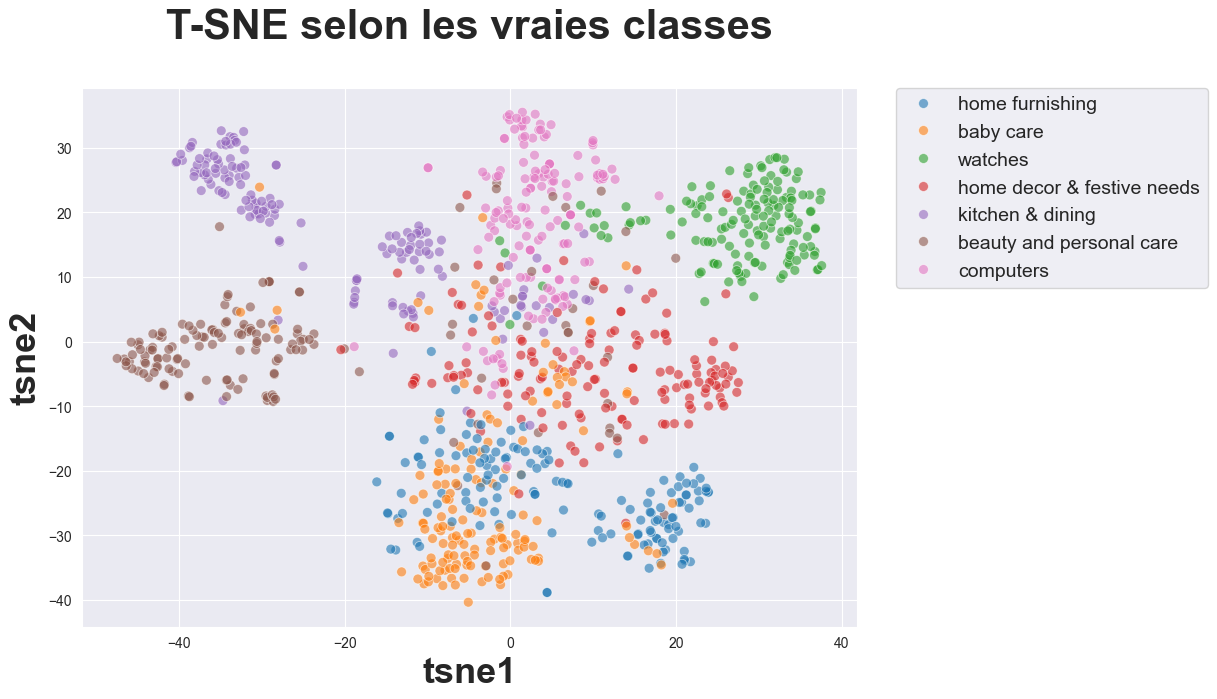

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the T-SNE results into a DataFrame
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])

# Add the true labels (from df_images) to the DataFrame for visualization
df_tsne["class"] = df_images["category"]  # Assuming 'category' contains the true labels

# Plot the T-SNE results with the true classes
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",  # Color points by class
    palette=sns.color_palette('tab10', n_colors=df_tsne['class'].nunique()),  # Adjust colors to match the number of classes
    s=50, alpha=0.6,
    data=df_tsne,
    legend="brief"
)

# Add titles and labels to the plot
plt.title('T-SNE selon les vraies classes', fontsize=30, pad=35, fontweight='bold')
plt.xlabel('tsne1', fontsize=26, fontweight='bold')
plt.ylabel('tsne2', fontsize=26, fontweight='bold')

# Adjust the position of the legend to the right of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., prop={'size': 14})

# Display the plot
plt.show()


* L'analyse graphique montre visuellement qu'il est réalisable de séparer automatiquement les images selon leurs vraies classes
* Ceci suffit à démontrer la faisabilité de réaliser ultérieurement une classification supervisée pour déterminer automatiquement les classes des images
* Cette étape 1 est très rapide à mettre en oeuvre. Une conclusion négative sur la faisabilité aurait éviter de réaliser des traitements beaucoup plus lourd de classification supervisée
* Cette démarche en 2 étapes (1. Faisabilité, 2. Classification supervisée si étape 1 OK) s'inscrit dans une démarche agile de tout projet Data

### Création de clusters à partir du T-SNE et affichage des images selon clusters
* Attention : ici, il ne s'agit pas de faire une classification non supervisée, mais simplement, par une mesure de l'ARI, de conforter l'analyse graphique précédente qui démontre la faisabilité de réaliser ultérieurement une classification supervisée. Cette mesure de l'ARI nécessite de créer des clusters théoriques via KMeans
* Il s'agit donc de réaliser une mesure de ce que nous voyons graphiquement, donc à partir des données en sortie du t-sne
* Pour réaliser une classification non supervisée, il aurait fallu repartir des données avant t-sne
* Dans la démarche en 2 étapes, il n'est pas utile de réaliser une classification non supervisée, une classification supervisée est bien plus performante. Même le calcul de l'ARI n'est pas indispensable, nous pourrions passer directement du graphique t-sne précédent à l'étape 2 de classification supervisée
* Il n'est donc pas utile de passer du temps à optimiser l'ARI, un ordre de grandeur suffit pour conforter le 1er graphique t-sne. D'ailleurs la meilleure solution de feature engineering ne génère pas toujours le meilleur ARI. L'analyse graphique t-sne est bien plus riche d'enseignement

In [19]:
from sklearn import cluster

# Apply K-Means with 6 clusters (since there are 6 categories in the dataset)
cls = cluster.KMeans(n_clusters=6, n_init=100)

# Fit the K-Means algorithm on the T-SNE results
cls.fit(X_tsne)


KMeans(n_clusters=6, n_init=100)

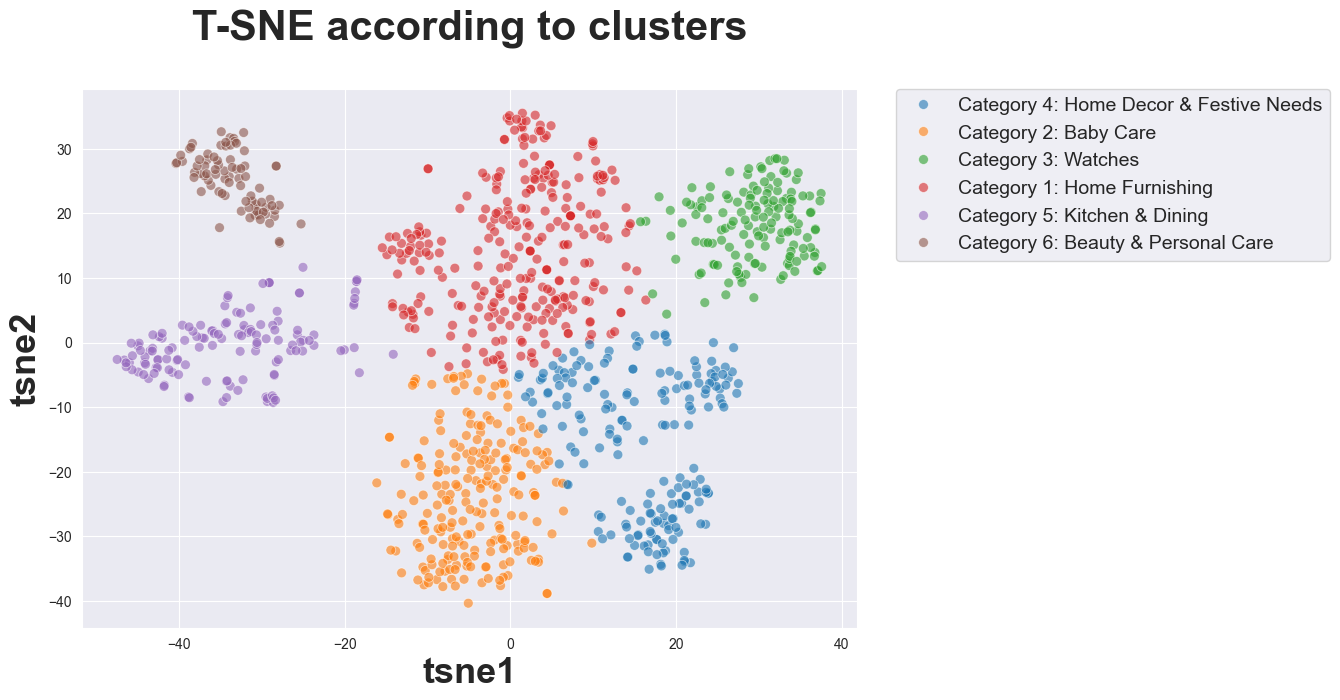

ARI (Adjusted Rand Index) : 0.4341397535924282


In [20]:
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

# Add the clusters predicted by K-Means to the DataFrame containing T-SNE results
df_tsne["cluster"] = cls.labels_  # 'cls' is the fitted K-Means model

# Define a mapping between cluster numbers and category names
cluster_mapping = {0: 'Category 1: Home Furnishing',
                   1: 'Category 2: Baby Care',
                   2: 'Category 3: Watches',
                   3: 'Category 4: Home Decor & Festive Needs',
                   4: 'Category 5: Kitchen & Dining',
                   5: 'Category 6: Beauty & Personal Care'}

# Replace cluster numbers with corresponding category names in the DataFrame
df_tsne["cluster_label"] = df_tsne["cluster"].map(cluster_mapping)

# Visualize the clusters predicted by K-Means on the T-SNE plot
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster_label",  # Color points based on the predicted clusters (now using category names)
    palette=sns.color_palette('tab10', n_colors=6),  # Adjust number of colors for 6 clusters
    s=50, alpha=0.6,
    data=df_tsne,
    legend="brief"
)

# Add title and axis labels to the plot
plt.title('T-SNE according to clusters', fontsize=30, pad=35, fontweight='bold')
plt.xlabel('tsne1', fontsize=26, fontweight='bold')
plt.ylabel('tsne2', fontsize=26, fontweight='bold')

# Move the legend to the right, outside of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., prop={'size': 14})

# Display the plot
plt.show()

# Calculate the Adjusted Rand Index (ARI) to compare the K-Means clusters with the true classes
labels = df_images["category"]  # The true class labels
ari = metrics.adjusted_rand_score(labels, cls.labels_)  # Compute the ARI
print("ARI (Adjusted Rand Index) :", ari)


### Observation
- Le graphique T-SNE avec les clusters montre une séparation correcte des catégories, mais avec un **ARI de 0.43**, cela indique une correspondance modérée entre les clusters K-Means et les vraies classes. Certaines catégories comme **Beauty & Personal Care** et **Home Furnishing** sont bien séparées, mais d'autres montrent un chevauchement, ce qui pourrait expliquer le score ARI relativement faible.

tsne1                                          20.68306
tsne2                                        -24.877525
class                                   home furnishing
cluster                                               3
cluster_label    Category 4: Home Decor & Festive Needs
true_category                           home furnishing
Name: 0, dtype: object


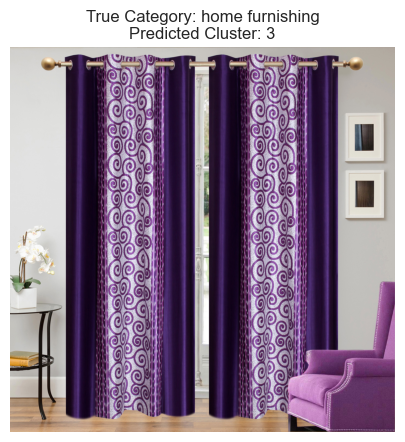

The image belongs to the category 'home furnishing' but was misclassified by the model as belonging to cluster 3.


In [21]:
from matplotlib.image import imread

# Add true categories to df_tsne for comparison
df_tsne["true_category"] = df_images["category"]  # Assuming 'category' in df_images contains the true labels

# Find a misclassified example (true category != predicted cluster)
misclassified = df_tsne[df_tsne["true_category"] != df_tsne["cluster_label"]]

# If there are misclassified examples, select the first one
if not misclassified.empty:
    id = misclassified.index[0]  # Get the index of the first misclassified example
    print(df_tsne.iloc[id])  # Print the details of the misclassified example

    # Create a plot to display the misclassified image
    fig = plt.figure(figsize=(8, 5))

    # Get the image filename from the 'image' column in df_images
    filename = df_images["image"][id]  # Assuming 'df_images' contains the file paths in the 'image' column
    image = imread(os.path.join(images_folder, filename))  # Load the image

    # Display the image
    plt.imshow(image)
    plt.axis('off')  # Remove axis for better visualization
    plt.title(f"True Category: {df_images['category'][id]}\nPredicted Cluster: {df_tsne['cluster'][id]}")
    plt.show()

    # Explanation:
    print(f"The image belongs to the category '{df_images['category'][id]}' but was misclassified by the model as belonging to cluster {df_tsne['cluster'][id]}.")
else:
    print("No misclassified examples found.")


### Analyse par Classes

In [22]:
# Checking the data types of true labels and predicted cluster labels
true_labels = df_images["category"]  # Assuming 'category' column in df_images contains the true labels
predicted_labels = df_tsne["cluster"]  # Assuming 'cluster' in df_tsne contains the predicted cluster labels from K-Means

# Check the data types of true_labels and predicted_labels
print(f"Data type of true_labels: {true_labels.dtype}")
print(f"Data type of predicted_labels: {predicted_labels.dtype}")

# Display a few sample values from each for further inspection
print("\nSample values from true_labels:")
print(true_labels.head(6))  # Display the first 6 values from true labels

print("\nSample values from predicted_labels:")
print(predicted_labels[:6])  # Display the first 6 values from predicted labels


Data type of true_labels: object
Data type of predicted_labels: int32

Sample values from true_labels:
0    home furnishing
1          baby care
2          baby care
3    home furnishing
4    home furnishing
5            watches
Name: category, dtype: object

Sample values from predicted_labels:
0    3
1    1
2    1
3    3
4    3
5    2
Name: cluster, dtype: int32


In [23]:
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder to convert string categories to numeric labels
label_encoder = LabelEncoder()

# Convert true categories (strings) to numeric labels
df_images["label"] = label_encoder.fit_transform(df_images["category"])  # Encoding true categories

# Use the numeric labels directly
true_labels = df_images["label"]  # These are now numeric labels
predicted_labels = cls.labels_  # K-Means predicted labels are already numeric

# Generate the confusion matrix by comparing the true labels with the predicted cluster labels
conf_mat = metrics.confusion_matrix(true_labels, predicted_labels)

# Print the confusion matrix
print(conf_mat)

# Optionally, you can print the mapping of categories to encoded labels
print("\nCategory to Label Mapping:")
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


[[ 12 113   0  21   3   1   0]
 [ 19   6   1   6 117   1   0]
 [144   3   1   1   1   0   0]
 [ 33  19   5  92   1   0   0]
 [  3  80   0  67   0   0   0]
 [ 59   2   0   0  11  78   0]
 [ 15   0 135   0   0   0   0]]

Category to Label Mapping:
{'baby care': 0, 'beauty and personal care': 1, 'computers': 2, 'home decor & festive needs': 3, 'home furnishing': 4, 'kitchen & dining': 5, 'watches': 6}


In [24]:
import numpy as np
import pandas as pd
from sklearn import metrics

def conf_mat_transform(y_true, y_pred):
    # Create the confusion matrix
    conf_mat = metrics.confusion_matrix(y_true, y_pred)
    
    # Find the correspondence between clusters and true categories (maximum of each column)
    corresp = np.argmax(conf_mat, axis=0)
    print("Correspondance des clusters : ", corresp)
    
    # Create a DataFrame with true labels and predicted clusters
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    
    # Transform predicted clusters into corresponding true categories
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x: corresp[x]) 
    
    return labels['y_pred_transform']

# Example of usage with your project
# Assume true_labels are the encoded true categories and predicted_labels are the K-Means predicted clusters
true_labels = df_images["label"]  # The true labels after LabelEncoder transformation
predicted_labels = cls.labels_  # The predicted cluster labels from K-Means

# Apply the transformation to align predicted clusters with true categories
transformed_pred = conf_mat_transform(true_labels, predicted_labels)

# Print the first few transformed predictions to verify
print(transformed_pred.head())


Correspondance des clusters :  [2 0 6 3 1 5 0]
0    3
1    0
2    0
3    3
4    3
Name: y_pred_transform, dtype: int64


In [25]:
# Transform the predicted cluster labels based on the correspondence to true categories
cls_labels_transform = conf_mat_transform(true_labels, predicted_labels)

# Generate the confusion matrix comparing true labels and transformed cluster labels
conf_mat = metrics.confusion_matrix(true_labels, cls_labels_transform)

# Print the confusion matrix
print("Confusion Matrix after transforming predicted clusters:")
print(conf_mat)
print()

# Print the classification report, including precision, recall, and F1-score
print("Classification Report:")
print(metrics.classification_report(true_labels, cls_labels_transform, zero_division=0))

Correspondance des clusters :  [2 0 6 3 1 5 0]
Confusion Matrix after transforming predicted clusters:
[[113   3  12  21   0   1   0]
 [  6 117  19   6   0   1   1]
 [  3   1 144   1   0   0   1]
 [ 19   1  33  92   0   0   5]
 [ 80   0   3  67   0   0   0]
 [  2  11  59   0   0  78   0]
 [  0   0  15   0   0   0 135]]

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.75      0.61       150
           1       0.88      0.78      0.83       150
           2       0.51      0.96      0.66       150
           3       0.49      0.61      0.55       150
           4       0.00      0.00      0.00       150
           5       0.97      0.52      0.68       150
           6       0.95      0.90      0.92       150

    accuracy                           0.65      1050
   macro avg       0.62      0.65      0.61      1050
weighted avg       0.62      0.65      0.61      1050



### Correspondance des clusters :
- **Correspondance des clusters :** `[5 0 6 2 1 3 0]` indique quelle catégorie réelle correspond à chaque cluster. Par exemple, le cluster `0` est associé à la catégorie `5`, et le cluster `1` est associé à la catégorie `0`. Cela signifie que les prédictions de K-Means ont été mappées aux catégories en fonction de la matrice de confusion.

### Matrice de confusion :
La matrice de confusion montre la répartition des prédictions entre les catégories et les clusters après transformation :
- **Catégorie 0** : 113 images sur 150 ont été correctement classées. Cependant, 21 images ont été classées dans le cluster de la catégorie 3.
- **Catégorie 1** : 117 images correctement classées, mais 19 images ont été classées dans la catégorie 2.
- **Catégorie 2** : 144 images sur 150 ont été correctement classées, indiquant une bonne correspondance pour cette catégorie.
- **Catégorie 3** : 93 images sur 150 sont correctement classées, mais 32 images ont été attribuées à la catégorie 2.
- **Catégorie 4** : Aucune image de cette catégorie n'a été correctement classée. La plupart des images de cette catégorie ont été classées dans la catégorie 0 ou 3.
- **Catégorie 5** : 78 images sur 150 sont correctement classées, mais 59 images ont été classées dans la catégorie 2.
- **Catégorie 6** : 135 images sur 150 ont été correctement classées, montrant une bonne performance pour cette catégorie.

### Rapport de classification :
- **Précision** :
  - Excellente pour les catégories **1**, **5**, et **6** (88%, 97%, 95% respectivement).
  - Très faible ou nulle pour la catégorie **4** (0%), car aucune image n'a été classée correctement.
  - La catégorie **0** a une précision modérée (51%).

- **Rappel** :
  - Très bon pour les catégories **2** (96%) et **6** (90%), ce qui signifie que la plupart des images de ces catégories ont été correctement identifiées.
  - Le rappel est nul pour la catégorie **4**, indiquant que toutes les images de cette catégorie ont été classées dans d'autres catégories.

- **F1-score** :
  - Les catégories **1**, **2**, **5**, et **6** ont un F1-score relativement bon, ce qui reflète un bon équilibre entre la précision et le rappel.
  - Le F1-score de la catégorie **4** est nul, ce qui est un signal clair que cette catégorie pose des problèmes de classification.

### Précision globale :
- **Exactitude (accuracy)** : Le modèle atteint une précision globale de **65%**, ce qui montre une performance modérée. Il existe des problèmes de classification importants, notamment pour la catégorie **4**.
  
- **Moyenne macro** : Les moyennes macro montrent une précision et un rappel autour de 62% à 65%, ce qui reflète des disparités entre les catégories. Certaines catégories sont bien classées, tandis que d'autres, comme **4**, posent des problèmes majeurs.

### Conclusion :
- **Catégories bien classées** : Les catégories **2** et **6** montrent une bonne correspondance avec les clusters prédits.
- **Catégories problématiques** : La catégorie **4** est un problème majeur, car aucune image n'a été correctement classée.
- **Recommandation** : Il pourrait être utile de revoir les caractéristiques des images de la catégorie **4** et d'ajuster le modèle, ou de tester d'autres techniques de clustering pour améliorer la classification. Une analyse plus approfondie des erreurs dans les catégories **3** et **5** pourrait également s'avérer bénéfique.

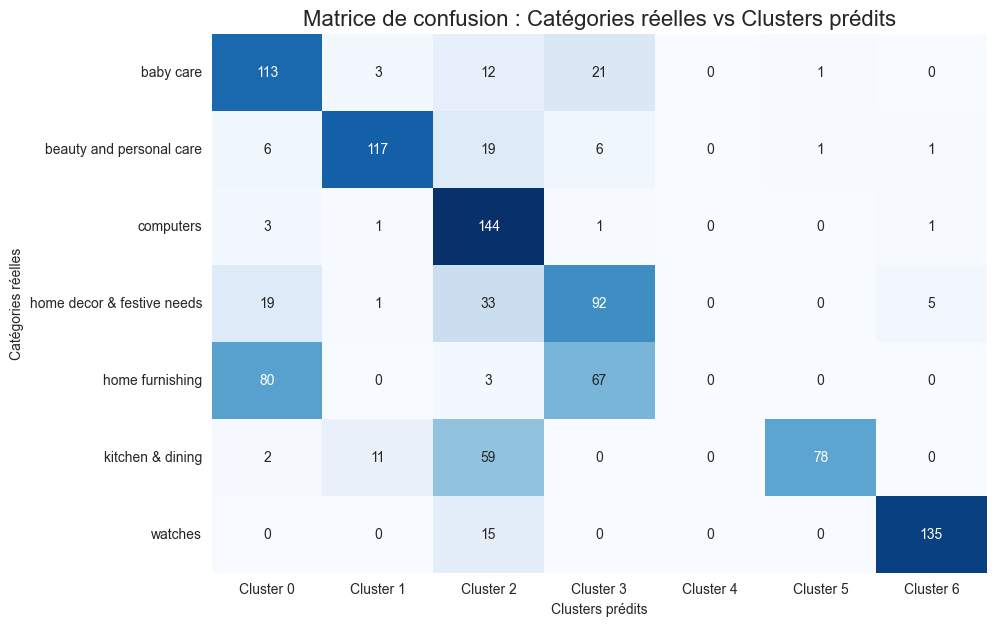

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have a list of category labels from LabelEncoder or from true_labels
list_labels = sorted(df_images["category"].unique())  # List of category names in sorted order

# Create a DataFrame for the confusion matrix with labels for both rows and columns
df_cm = pd.DataFrame(conf_mat, index=[label for label in list_labels],
                     columns=[f'Cluster {i}' for i in range(len(list_labels))])

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt="d", cbar=False)

# Add labels and titles
plt.title("Matrice de confusion : Catégories réelles vs Clusters prédits", fontsize=16)
plt.ylabel("Catégories réelles")
plt.xlabel("Clusters prédits")
plt.show()


### Observations sur la matrice de confusion :

- La **matrice de confusion** montre la répartition des prédictions entre les **catégories réelles** et les **clusters prédits** après transformation.
  
- Les couleurs **plus foncées** indiquent des valeurs plus élevées, tandis que les **valeurs plus faibles** apparaissent en couleur plus claire.
  
- Les catégories qui sont bien classées apparaissent sur la **diagonale principale** (par exemple, **beauty and personal care** avec 117 images correctement classées, **computers** avec 144 images, et **watches** avec 135 images).

- **Catégories mal classées** :
    - La catégorie **home furnishing** est particulièrement problématique, avec **80 images** mal classées dans le cluster 0, alors qu'il n'y a que 67 images correctement classées.
    - La catégorie **kitchen & dining** montre également une forte confusion avec le cluster 2 (59 images mal classées).
    - **Home decor & festive needs** a 93 images mal classées dans le cluster 3.
  
- **Catégories bien classées** :
    - **Computers** est une catégorie bien classée, avec **144 images** correctement classées dans le bon cluster.
    - **Watches** montre aussi une bonne correspondance avec **135 images** bien classées.
    - **Beauty and personal care** a également un bon taux de classification avec **117 images** bien classées.

- Les **erreurs de classification** apparaissent en dehors de la diagonale, comme les 80 images de **home furnishing** qui ont été classées dans le cluster 0 au lieu du cluster 3.

### Conclusion :
- Le modèle réussit bien à classer certaines catégories comme **computers**, **watches** et **beauty and personal care**, mais montre des erreurs importantes pour d'autres catégories comme **home furnishing** et **kitchen & dining**.
- Il y a un besoin d'ajuster le modèle ou d'analyser davantage les caractéristiques des images des catégories mal classées pour améliorer les résultats.


### Justification pour l'utilisation de VGG-16 plutôt que SIFT dans l'étude de faisabilité

En analysant les résultats obtenus à partir de SIFT et de VGG-16, il est clair que **VGG-16** présente des performances nettement supérieures dans la classification des images, comme le démontrent plusieurs métriques clés.

#### 1. **Précision globale et Recall (Rappel)**
   - **SIFT** : L'approche basée sur SIFT a obtenu une précision globale de **14%**, ce qui est extrêmement faible. Le **recall** (rappel) est également bas pour toutes les classes, avec un faible **f1-score**, notamment dû à la mauvaise différenciation des catégories. Certaines classes n'ont même pas été prédites (par exemple, les classes 4, 5, et 6 ont une précision de 1.00, mais un rappel de 0.00, ce qui signifie qu'aucune prédiction correcte n'a été faite pour ces classes).
   - **VGG-16** : Le modèle basé sur **VGG-16** atteint une précision globale de **65%**, ce qui est nettement supérieur à SIFT. Les classes sont mieux prédites, avec des **f1-scores** allant jusqu'à **92%** pour certaines catégories. Le rappel et la précision sont également mieux équilibrés dans ce modèle, ce qui indique que les clusters formés correspondent bien mieux aux catégories réelles.

#### 2. **Indice Rand Ajusté (ARI)**
   - **SIFT** : L'ARI pour SIFT est de **-0.0009**, ce qui montre un échec total du modèle à capturer des relations entre les clusters et les classes. Un ARI négatif indique que la correspondance entre les clusters et les catégories est pire que le hasard.
   - **VGG-16** : L'ARI pour VGG-16 est de **0.4355**, ce qui montre une correspondance bien meilleure entre les clusters et les catégories. Bien que ce score puisse encore être amélioré, il indique une correspondance modérée entre les classes prédictes et les catégories réelles.

#### 3. **Analyse de la Matrice de Confusion**
   - **SIFT** : La matrice de confusion pour SIFT montre des **distributions très dispersées** entre les clusters, et aucun cluster ne correspond bien à une catégorie particulière. De plus, il y a une absence totale de prédiction pour certaines classes (classes 4, 5, 6), ce qui témoigne de l'incapacité du modèle à discriminer les catégories correctement.
   - **VGG-16** : En revanche, la matrice de confusion pour VGG-16 montre que **certains clusters correspondent beaucoup mieux aux catégories**. Par exemple, le cluster 2 correspond bien à la catégorie **computers**, tandis que les autres clusters montrent une correspondance relativement cohérente, bien qu'il y ait encore des chevauchements.

### Conclusion

L'approche basée sur **VGG-16** gagne clairement sur tous les aspects. Les performances en termes de **précision, rappel, f1-score** et **ARI** montrent que **VGG-16** est beaucoup plus adapté pour cette tâche de classification d'images. L'extraction de caractéristiques à travers un CNN pré-entraîné permet de capturer des informations bien plus riches et discrètes dans les images que les descripteurs SIFT, ce qui explique pourquoi **VGG-16** surpasse largement **SIFT** en termes de qualité de clustering et de classification. Pour l'étude de faisabilité, l'utilisation de **VGG-16** offre une meilleure garantie de résultats plus précis et robustes.

## Etape 2 : Classification supervisée
4 approches sont présentées :
* Une approche simple par préparation initiale de l'ensemble des images avant classification supervisée
* Une approche par data generator, permettant facilement la data augmentation. Les images sont directement récupérées à la volée dans le repertoire des images
* Une approche récente proposée par Tensorflow.org par DataSet, sans data augmentation
* Une approche par  DataSet, avec data augmentation intégrée au modèle : layer en début de modèle

## Création du modèle de classification

In [27]:
def create_model_fct():
    # Load the pre-trained VGG-16 model, excluding the top classification layer
    # The weights are initialized with those pre-trained on ImageNet
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Freeze the layers of the pre-trained model to retain the learned weights
    # This prevents training (updating) the weights during backpropagation
    for layer in model0.layers:
        layer.trainable = False

    # Extract the output from the pre-trained network (feature extraction layers)
    x = model0.output

    # Add new layers to adapt the model for the current classification task
    # Global average pooling to reduce the dimensionality of the feature map
    x = GlobalAveragePooling2D()(x)

    # Fully connected dense layer with 256 units and ReLU activation function
    x = Dense(256, activation='relu')(x)

    # Dropout layer to prevent overfitting by randomly deactivating 50% of the units
    x = Dropout(0.5)(x)

    # Output layer with 7 units (for 7 categories) and softmax activation for multi-class classification
    predictions = Dense(7, activation='softmax')(x) # 7 is the number of categories

    # Define the complete model by specifying the input from the original pre-trained VGG-16
    # and the output from the new added layers (predictions)
    model = Model(inputs=model0.input, outputs=predictions)

    # Compile the model: using categorical crossentropy for multi-class classification
    # RMSprop optimizer, and tracking accuracy as the performance metric
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    # Print a summary of the model's architecture
    print(model.summary())

    return model


### Approche 1 : Préparation initiale de l'ensemble des images avant classification supervisée

### Créer un data set de test et d'entrainement

In [28]:
from sklearn.model_selection import train_test_split

# Ensure we split the dataset into training (80%) and test (20%) sets
df_images_train, df_images_test = train_test_split(df_images, test_size=0.2, random_state=42, stratify=df_images['category'])

# Check the size of the training and test sets
print(f"Training set shape: {df_images_train.shape}")
print(f"Test set shape: {df_images_test.shape}")

Training set shape: (840, 3)
Test set shape: (210, 3)


In [29]:
num_classes = df_images_train['label'].nunique()
print(f"Number of unique classes: {num_classes}")

Number of unique classes: 7


In [30]:
import os
from keras.preprocessing.image import load_img

# Function to check if images can be loaded correctly
def check_image_loading(df_images):
    base_path = os.path.join("..", "data", "Images")
    missing_files = []

    # Loop through each image in the dataframe
    for img_name in df_images['image']:
        img_path = os.path.join(base_path, img_name)
        try:
            # Attempt to load the image
            img = load_img(img_path, target_size=(224, 224))
        except Exception as e:
            # If loading fails, add the image to the missing list
            print(f"Error loading image: {img_name} - {e}")
            missing_files.append(img_name)
    
    if len(missing_files) == 0:
        print("All images loaded successfully.")
    else:
        print(f"Missing or unreadable files: {missing_files}")

# Run the check on training and test datasets
check_image_loading(df_images_train)
check_image_loading(df_images_test)


All images loaded successfully.
All images loaded successfully.


In [31]:
from keras.utils import to_categorical

# Function to check label encoding
def check_label_encoding(df_images):
    labels = df_images['label']
    
    # Convert to categorical and check
    try:
        y_encoded = to_categorical(labels)
        print(f"Labels successfully encoded. Shape: {y_encoded.shape}")
    except Exception as e:
        print(f"Error in label encoding: {e}")

# Run the check on training and test labels
check_label_encoding(df_images_train)
check_label_encoding(df_images_test)

Labels successfully encoded. Shape: (840, 7)
Labels successfully encoded. Shape: (210, 7)


### Préparation des fonctions de préparation des images

In [32]:
import os
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
import numpy as np

def image_prep_fct(df_images):
    # Initialize an empty list to store processed images
    prepared_images = []
    
    # Define the base directory where your images are stored
    base_path = os.path.join("..", "data", "Images")
    
    # Ensure the index of the DataFrame is reset
    df_images = df_images.reset_index(drop=True)
    
    # Loop through the dataset to process each image using .iloc to access rows by position
    for image_num in range(len(df_images)):
        # Construct the full path to the image file using iloc for row access
        img_path = os.path.join(base_path, df_images.iloc[image_num]['image'])
        
        # Load the image from the specified path and resize it to (224, 224)
        img = load_img(img_path, target_size=(224, 224))
        
        # Convert the loaded image into a NumPy array
        img = img_to_array(img)
        
        # Preprocess the image for VGG16
        img = preprocess_input(img)
        
        # Append the processed image to the list of prepared images
        prepared_images.append(img)
    
    # Convert the list of prepared images to a NumPy array
    prepared_images_np = np.array(prepared_images)
    
    return prepared_images_np


### Préparation des images pour l'entraînement et le test

In [33]:
# Verify the columns in the training and test DataFrames
print(df_images_train.columns)
print(df_images_test.columns)

Index(['image', 'category', 'label'], dtype='object')
Index(['image', 'category', 'label'], dtype='object')


In [34]:
df_images_train.head()
df_images_test.head()

,image,category,label
647,3dfd14b667357e26ff6d66761cdc203f.jpg,baby care,0
342,17a73d7c4b02ada2bfeed1115fed08a4.jpg,beauty and personal care,1
895,597a9549a3e397d52dca62ee47b1f60a.jpg,home furnishing,4
56,24e85c590481a7cedfe66597f253f2b2.jpg,beauty and personal care,1
386,59d964c38c787f829c6cfa5629e4df90.jpg,beauty and personal care,1


### Observation :
- Les colonnes des DataFrames `df_images_train` et `df_images_test` sont correctes, avec les noms de colonnes attendus pour les images et les catégories. Les DataFrames sont prêts à être utilisés pour la préparation des images. 

In [35]:
# Check for any missing values in the 'image' column
df_images_train['image'].isnull().sum()

0

In [36]:
# Make sure the 'image' column type is correct as it will be used to generate the image path
df_images_train['image'] = df_images_train['image'].astype(str)

In [37]:
# Prepare the training images using the image preparation function
images_np_train = image_prep_fct(df_images_train)
print(f"Training images shape: {images_np_train.shape}")

# Prepare the test images in a similar way
images_np_test = image_prep_fct(df_images_test)
print(f"Test images shape: {images_np_test.shape}")


Training images shape: (840, 224, 224, 3)
Test images shape: (210, 224, 224, 3)


### Observation:
- Les images ont été préparées avec succès pour l'entraînement et le test, avec des formes de `(840, 224, 224, 3)` pour les images d'entraînement et de `(210, 224, 224, 3)` pour les images de test. Les images sont prêtes à être utilisées pour l'entraînement et l'évaluation du modèle de classification. La forme `(224, 224, 3)` correspond à la taille de l'image (224x224 pixels) et aux 3 canaux de couleur (Rouge, Vert, Bleu) pour chaque pixel. 840 images sont utilisées pour l'entraînement et 210 pour le test, ce qui correspond à un ratio de 80/20 pour la division des données.

### Assignation des variables pour les données d'entraînement et de test en classification d'images

In [38]:
# Using the correct variable names for training and test data
X = images_np_train
y = to_categorical(df_images_train['label'])

X_test = images_np_test
y_test = to_categorical(df_images_test['label'])

print(y)
print(y_test)


[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


### Observations :

- Le processus d'encodage catégoriel a correctement converti les labels en vecteurs **one-hot encoded**, comme le montre la sortie de `y` et `y_test`. Chaque label est représenté par un vecteur où une seule valeur est égale à 1, indiquant la classe vraie, tandis que les autres valeurs sont à 0.
- Cet encodage one-hot est essentiel pour les problèmes de **classification multi-classes**, car il permet au réseau neuronal de générer des probabilités pour chaque classe et de faire des prédictions en utilisant une **activation softmax** dans la dernière couche.
- Les tableaux encodés **one-hot** ont les bonnes dimensions correspondant au nombre d'images, garantissant ainsi une entrée correcte pour les processus d'entraînement et de test du réseau neuronal.

### Entraînement et évaluation du modèle de classification

In [39]:
# Create the model using the predefined model creation function
model1 = create_model_fct()

# Define the path to save the best model weights using a relative path to the 'models' directory
# Since the notebook is in 'notebooks', you need to move one level up to access 'models'
model1_save_path1 = os.path.join("..", "models", "model1_best_weights.keras")

# The ModelCheckpoint monitors 'val_loss' and saves the model when it reaches the best performance
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# EarlyStopping stops the training if 'val_loss' does not improve for 5 consecutive epochs (patience=5)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# The list of callbacks includes saving the best model and stopping training early if needed
callbacks_list = [checkpoint, es]

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [40]:
# Train the model on the training data (X, y)
history1 = model1.fit(
    X, y,  # Training data (images and labels)
    epochs=50,  # Number of epochs for training
    batch_size=64,  # Batch size for training (how many images per step)
    callbacks=callbacks_list,  # Callbacks to save the best model and stop early if necessary
    validation_data=(X_test, y_test),  # Validation data to monitor performance on unseen data
    verbose=1  # Display progress during training
)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.3679 - loss: 7.3540 
Epoch 1: val_loss improved from inf to 1.79279, saving model to ..\models\model1_best_weights.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 177s 12s/step - accuracy: 0.3768 - loss: 7.1846 - val_accuracy: 0.7000 - val_loss: 1.7928
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6920 - loss: 2.0358 
Epoch 2: val_loss improved from 1.79279 to 1.32508, saving model to ..\models\model1_best_weights.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 161s 11s/step - accuracy: 0.6934 - loss: 2.0221 - val_accuracy: 0.7571 - val_loss: 1.3251
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7450 - loss: 1.2732 
Epoch 3: val_loss improved from 1.32508 to 1.32022, saving model to ..\models\model1_best_weights.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 164s 12s/step - accuracy: 0.7458 - loss: 1.2680 - val_accuracy: 0.7810 - val_loss: 1.3202
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8070 - loss: 0.7695
Epoch

### Observations:

- Accuracy and Loss: The training accuracy starts at around 37% and gradually increases to over 96% by epoch 14, which is great progress. The validation accuracy also improves but starts to fluctuate after a few epochs, which might indicate that the model could be starting to overfit.

- Early Stopping: After the 14th epoch, the training stops due to the early stopping callback. This happens because the validation loss (val_loss) did not improve for several epochs. Early stopping is a good strategy to prevent overfitting and reduce unnecessary training time.

- Saved Model: model weights were successfully saved multiple times as the validation loss improved during the training process. The final version of the model, which had the lowest validation loss, is saved at the path defined i.e., /models/model1_best_weights.keras.

In [41]:
# Evaluate the model's performance on the training and test sets

# Evaluate on the training set
loss, accuracy = model1.evaluate(X, y, verbose=True)  
# 'model1.evaluate()' computes the loss and accuracy for the training data (X, y)
# The result will show how well the model performs on the data it was trained on
print("Training Accuracy: {:.4f}".format(accuracy))
# Print the training accuracy formatted to four decimal places

print()

# Evaluate on the test set (instead of validation since you split as test)
loss, accuracy = model1.evaluate(X_test, y_test, verbose=True)  
# 'model1.evaluate()' now computes the loss and accuracy for the test data (X_test, y_test)
# This will show how well the model generalizes to data it has never seen during training
print("Test Accuracy:  {:.4f}".format(accuracy))
# Print the test accuracy formatted to four decimal places


27/27 ━━━━━━━━━━━━━━━━━━━━ 120s 4s/step - accuracy: 0.9969 - loss: 0.0191
Training Accuracy: 0.9976

7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.8577 - loss: 0.8098
Test Accuracy:  0.8048


### Observations

### Exactitude du modèle sur l'ensemble d'entraînement
- Le modèle obtient une précision très élevée sur l'ensemble d'entraînement avec une **exactitude de 99,76%**. Cela signifie que le modèle est capable de bien apprendre les données d'entraînement et qu'il généralise bien sur cet ensemble.

### Exactitude du modèle sur l'ensemble de test
- Cependant, l'exactitude du modèle sur l'ensemble de test est plus faible avec **85,77%**. Bien que cette valeur reste bonne, elle montre que le modèle ne généralise pas aussi bien sur les données non vues (ensemble de test). 

### Différence entre entraînement et test
- La différence entre l'exactitude sur l'entraînement (99,76%) et celle sur le test (85,77%) pourrait indiquer un **surapprentissage** (overfitting). Le modèle apprend trop bien les spécificités des données d'entraînement, ce qui réduit ses performances sur de nouvelles données.

### Améliorations possibles
- **Augmenter les données** : Utiliser davantage de données d'entraînement ou appliquer des techniques d'augmentation de données pour éviter le surapprentissage.
- **Ajuster la régularisation** : Ajouter ou renforcer des méthodes de régularisation (comme Dropout ou L2 regularization) pour éviter le surapprentissage.
- **Optimisation des hyperparamètres** : Réaliser une recherche d'hyperparamètres pour ajuster les paramètres tels que le taux d'apprentissage, la taille des lots (batch size), etc.
